Diarization with Pyannote.
Audio to memory with torch_audio

In [1]:
from pyannote.audio import Pipeline
import torch
from pyannote.core import Annotation
import torchaudio
from pyannote.core import notebook, Segment
from pydub import AudioSegment
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

/home/purity/.local/share/virtualenvs/speaker_identification-oHudkPfs/lib/python3.10/site-packages/pyannote/audio/core/io.py:43: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")
/home/purity/.local/share/virtualenvs/speaker_identification-oHudkPfs/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from inference import config
#loading model into pipeline
pipeline = Pipeline.from_pretrained("pyannote/speaker-diarization-3.1", use_auth_token=config.token)

# sending pipeline to GPU (when available)
pipeline.to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))

In [9]:
# getting audio to memory
waveform, sample_rate = torchaudio.load("output.wav")

print(f"{type(waveform)=}")
print(f"{waveform.shape=}")
print(f"{waveform.dtype=}")

audio_in_memory = {"waveform": waveform, "sample_rate": sample_rate}
audio_in_memory

type(waveform)=<class 'torch.Tensor'>
waveform.shape=torch.Size([1, 87997120])
waveform.dtype=torch.float32


{'waveform': tensor([[-0.0028, -0.0023, -0.0018,  ...,  0.0000,  0.0000,  0.0000]]),
 'sample_rate': 16000}

In [10]:
#applying the pretrained pipeline
dia = pipeline(audio_in_memory)

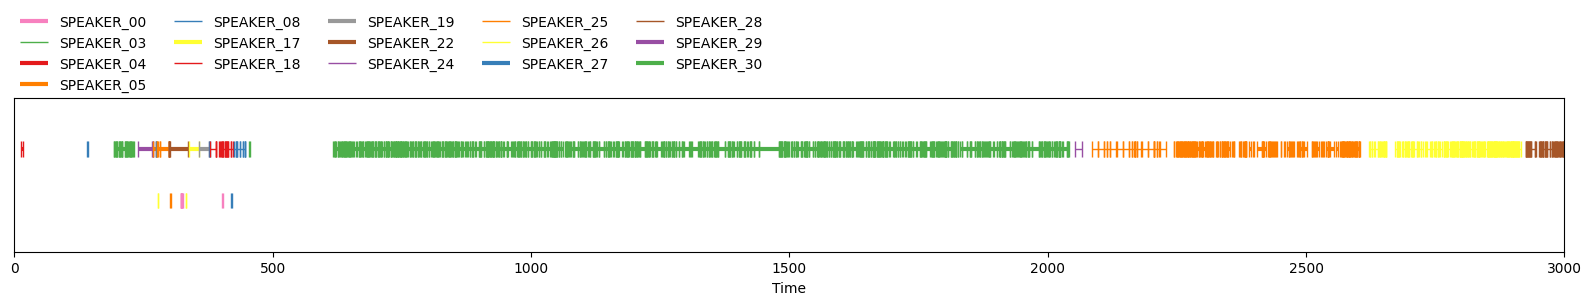

In [11]:
#visualizing the results
from pyannote.core import notebook, Segment
notebook.crop = Segment(0, 3000)
dia

Creating function for making a dataframe from the annotation results

In [12]:
def make_df(dia_results):
    for i, value in enumerate(dia_results):
            first_segment = value # getting first value from the results
            break

    speech_turn = first_segment[0]
    turn = first_segment[1]
    current_speaker = first_segment[2]
    start_time = f"{speech_turn.start:.1f}"
    end_time = f"{speech_turn.end:.1f}"

    speakers = []
    starting = []
    ending = []

    #iterating over the results to get the speakers, starting and end time
    for speech_turn, track, speaker in dia_results:
        start_turn = f"{speech_turn.start:.1f}"
        end_turn = f"{speech_turn.end:.1f}"
        #when different speaker is detected
        if speaker != current_speaker and start_turn != end_turn:
            speakers.append(current_speaker)
            starting.append(float(start_time))
            ending.append(float(end_time))
            current_speaker = speaker
            start_time = f"{speech_turn.start:.1f}"
            end_time = f"{speech_turn.end:.1f}"
        else:
            #start_time = start
            end_time = f"{speech_turn.end:.1f}"
            

    speakers.append(current_speaker)
    starting.append(float(start_time))
    ending.append(float(end_time))
            
    df = pd.DataFrame(list(zip(speakers, starting, ending)),
                columns =['speakers', 'start', 'end'])
    df['period'] = df['end'] - df['start']
    return df

In [13]:
df = make_df(dia.itertracks(yield_label=True))
print(df.shape)
df.head()

(73, 4)


,speakers,start,end,period
0,SPEAKER_04,13.1,16.7,3.6
1,SPEAKER_27,140.9,141.8,0.9
2,SPEAKER_30,191.9,230.8,38.9
3,SPEAKER_29,239.5,267.8,28.3
4,SPEAKER_05,267.8,273.9,6.1


In [75]:
df = make_df(dia.itertracks(yield_label=True))
print(df.shape)
df.head()

(76, 4)


,speakers,start,end,period
0,SPEAKER_06,13.1,16.7,3.6
1,SPEAKER_33,139.2,143.6,4.4
2,SPEAKER_30,191.9,230.8,38.9
3,SPEAKER_29,239.5,267.8,28.3
4,SPEAKER_07,267.8,267.9,0.1


In [14]:
df2 = df.drop_duplicates(subset=["start", "end"], keep='first')
print(df2.shape)
df2.head()

(73, 4)


,speakers,start,end,period
0,SPEAKER_04,13.1,16.7,3.6
1,SPEAKER_27,140.9,141.8,0.9
2,SPEAKER_30,191.9,230.8,38.9
3,SPEAKER_29,239.5,267.8,28.3
4,SPEAKER_05,267.8,273.9,6.1


In [76]:
df2 = df.drop_duplicates(subset=["start", "end"], keep='first')
print(df2.shape)
df2.head()

(76, 4)


,speakers,start,end,period
0,SPEAKER_06,13.1,16.7,3.6
1,SPEAKER_33,139.2,143.6,4.4
2,SPEAKER_30,191.9,230.8,38.9
3,SPEAKER_29,239.5,267.8,28.3
4,SPEAKER_07,267.8,267.9,0.1


In [15]:
# dropping audios less than 10sec
df3 = df2[df2['period']>=10]

In [77]:
df3 = df2[df2['period']>=10]

In [16]:
df3.reset_index(drop=True,inplace=True)
print(df3.shape)
df3.head()

(45, 4)


,speakers,start,end,period
0,SPEAKER_30,191.9,230.8,38.9
1,SPEAKER_29,239.5,267.8,28.3
2,SPEAKER_05,281.8,300.0,18.2
3,SPEAKER_22,300.0,335.2,35.2
4,SPEAKER_17,332.5,357.0,24.5


In [78]:
df3.reset_index(drop=True,inplace=True)
print(df3.shape)
df3.head()

(42, 4)


,speakers,start,end,period
0,SPEAKER_30,191.9,230.8,38.9
1,SPEAKER_29,239.5,267.8,28.3
2,SPEAKER_07,275.2,299.0,23.8
3,SPEAKER_26,298.0,335.1,37.1
4,SPEAKER_27,332.4,358.0,25.6


In [17]:
#merging consecutive audios from same speaker
def merge_consecutive_audios(df, condition_column):
    # Creating a mask to identify consecutive rows
    mask = df[condition_column] != df[condition_column].shift(1)

    # Assigning a group number to consecutive rows
    group_number = mask.cumsum()

    # Grouping by the consecutive groups and aggregate the data
    result_df = df.groupby([group_number], as_index=False).agg({
        condition_column: 'first',  # Take the first value in the group
        'start': 'first', 
             'end' :'last'    # Example: sum other columns if needed
    })
    #result_df['period'] = result_df['end'] - result_df['start']
    return result_df


result_df = merge_consecutive_audios(df3, 'speakers')
print(result_df)

      speakers   start     end
0   SPEAKER_30   191.9   230.8
1   SPEAKER_29   239.5   267.8
2   SPEAKER_05   281.8   300.0
3   SPEAKER_22   300.0   335.2
4   SPEAKER_17   332.5   357.0
5   SPEAKER_19   357.0   377.6
6   SPEAKER_18   379.3   422.7
7   SPEAKER_08   419.5   447.0
8   SPEAKER_30   617.1  2042.0
9   SPEAKER_24  2052.0  2066.9
10  SPEAKER_25  2085.7  2228.6
11  SPEAKER_05  2243.8  2604.2
12  SPEAKER_26  2621.6  2915.1
13  SPEAKER_28  2924.8  3075.4
14  SPEAKER_30  3082.8  3098.9
15  SPEAKER_27  3140.8  3378.0
16  SPEAKER_08  3392.5  3436.8
17  SPEAKER_21  3441.0  3492.5
18  SPEAKER_10  3497.5  3542.0
19  SPEAKER_02  3546.1  3708.6
20  SPEAKER_00  3715.6  3757.2
21  SPEAKER_20  3762.1  3828.6
22  SPEAKER_15  3834.6  3928.0
23  SPEAKER_14  3928.0  3941.0
24  SPEAKER_13  3965.9  3994.3
25  SPEAKER_11  3995.0  4008.0
26  SPEAKER_13  4008.0  4022.2
27  SPEAKER_11  4025.0  4132.4
28  SPEAKER_13  4135.4  4213.0
29  SPEAKER_23  4213.0  4385.3
30  SPEAKER_07  4386.0  4494.6
31  SPEA

In [79]:
#merging consecutive audios from same speaker
def merge_consecutive_audios(df, condition_column):
    # Creating a mask to identify consecutive rows
    mask = df[condition_column] != df[condition_column].shift(1)

    # Assigning a group number to consecutive rows
    group_number = mask.cumsum()

    # Grouping by the consecutive groups and aggregate the data
    result_df = df.groupby([group_number], as_index=False).agg({
        condition_column: 'first',  # Take the first value in the group
        'start': 'first', 
             'end' :'last'    # Example: sum other columns if needed
    })
    #result_df['period'] = result_df['end'] - result_df['start']
    return result_df


result_df = merge_consecutive_audios(df3, 'speakers')
print(result_df)

      speakers   start     end
0   SPEAKER_30   191.9   230.8
1   SPEAKER_29   239.5   267.8
2   SPEAKER_07   275.2   299.0
3   SPEAKER_26   298.0   335.1
4   SPEAKER_27   332.4   358.0
5   SPEAKER_24   358.0   377.6
6   SPEAKER_08   379.3   422.7
7   SPEAKER_10   419.4   442.9
8   SPEAKER_30   617.1  2042.0
9   SPEAKER_11  2052.0  2228.6
10  SPEAKER_07  2243.8  2604.2
11  SPEAKER_04  2621.6  2915.1
12  SPEAKER_28  2924.8  3075.5
13  SPEAKER_30  3082.8  3098.9
14  SPEAKER_33  3140.4  3378.0
15  SPEAKER_09  3392.5  3436.8
16  SPEAKER_25  3441.0  3492.5
17  SPEAKER_16  3497.5  3542.0
18  SPEAKER_14  3546.1  3708.6
19  SPEAKER_00  3715.6  3757.2
20  SPEAKER_22  3762.1  3828.6
21  SPEAKER_21  3834.6  3928.0
22  SPEAKER_20  3928.0  3940.0
23  SPEAKER_18  3965.9  4022.2
24  SPEAKER_17  4025.0  4132.4
25  SPEAKER_18  4135.4  4213.0
26  SPEAKER_12  4213.0  4385.3
27  SPEAKER_02  4386.0  4494.6
28  SPEAKER_19  4503.0  4649.6
29  SPEAKER_31  4705.0  4937.4
30  SPEAKER_32  4949.7  5054.9
31  SPEA

In [18]:
result_df.reset_index(inplace=True, drop=True)
print(result_df.shape)
result_df.head()

(39, 3)


,speakers,start,end
0,SPEAKER_30,191.9,230.8
1,SPEAKER_29,239.5,267.8
2,SPEAKER_05,281.8,300.0
3,SPEAKER_22,300.0,335.2
4,SPEAKER_17,332.5,357.0


In [81]:
result_df.reset_index(inplace=True, drop=True)
print(result_df.shape)
result_df.head()

(36, 3)


,speakers,start,end
0,SPEAKER_30,191.9,230.8
1,SPEAKER_29,239.5,267.8
2,SPEAKER_07,275.2,299.0
3,SPEAKER_26,298.0,335.1
4,SPEAKER_27,332.4,358.0


Speaker Verification

In [19]:
from pyannote.audio import Model
from pyannote.audio import Inference
from scipy.spatial.distance import cdist

In [20]:
# instantiate pretrained model
model = Model.from_pretrained("pyannote/wespeaker-voxceleb-resnet34-LM")
inference = Inference(model, window="whole")

In [28]:
#getting embeddings for different speakers and convert to 2D array
speaker1_embedding = inference("speaker1.mp3")
speaker1_embedding = speaker1_embedding.reshape(1,-1)
speaker2_embedding = inference("speaker2.mp3")
speaker2_embedding = speaker2_embedding.reshape(1,-1)
speaker3_embedding = inference("speaker3.mp3")
speaker3_embedding = speaker3_embedding.reshape(1,-1)
speaker4_embedding = inference("speaker4.mp3")
speaker4_embedding = speaker4_embedding.reshape(1,-1)
speaker5_embedding = inference("speaker5.mp3")
speaker5_embedding = speaker5_embedding.reshape(1,-1)

In [86]:
embedding_dict =  {'speaker1':speaker1_embedding,'speaker5':speaker5_embedding,'speaker2':speaker2_embedding, 'speaker3':speaker3_embedding,'speaker4':speaker4_embedding}

Saving Embeddings 

In [87]:
torch.save(embedding_dict, 'embedding_dict.pt')

In [21]:
embedding_dict = torch.load('embedding_dict.pt')

In [22]:
def create_embedding(x):
    embedding = inference(x)
    embedding = embedding.reshape(1,-1)
    return embedding

In [23]:
def get_similarity(x, y):
    distance = cdist(x, y, metric="cosine")[0,0]
    if distance <=0.35:
        ans = 'yes'
    else:
        ans = 'no'
    return ans

In [24]:
#cutting audios
audio_file = AudioSegment.from_mp3("/home/purity/Desktop/audiorecordings/output.wav")
for i in range(0,len(result_df)):
    speaker_list = list(result_df.values[i,:])
    #cutting audio
    start_cut = (speaker_list[1])*1000
    end_cut = (speaker_list[2])*1000
    speech_file = audio_file[start_cut:end_cut]
    audio_name = f"{speaker_list[0]}-{i}.mp3"
    
    #saving file
    speech_file.export(audio_name, format="mp3")
    embedding = create_embedding(audio_name)
    for key, value in embedding_dict.items():
        ans = get_similarity(embedding, value)
        if ans == 'yes':
            audio_name = f"{key}-{i}.mp3"
            speech_file.export(audio_name, format="mp3")
        else:
            continue